In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [86]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(384, scale=(0.8, 1.0)),  # Adjusted to better fit the original dimensions
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(512),  # Adjust resizing to be closer to original dimensions
        transforms.CenterCrop(384),  # Center crop to maintain aspect ratio
        transforms.ToTensor(),
    ]),
}


data_dir = 'data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

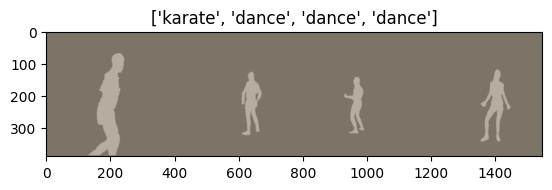

In [87]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [88]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [89]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 

In [90]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [91]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/24
----------


train Loss: 0.5946 Acc: 0.7168
val Loss: 0.7998 Acc: 0.6349

Epoch 1/24
----------
train Loss: 0.4425 Acc: 0.8096
val Loss: 0.7689 Acc: 0.6772

Epoch 2/24
----------
train Loss: 0.3913 Acc: 0.8514
val Loss: 0.6612 Acc: 0.6878

Epoch 3/24
----------
train Loss: 0.3180 Acc: 0.8744
val Loss: 0.8913 Acc: 0.6138

Epoch 4/24
----------
train Loss: 0.2635 Acc: 0.8953
val Loss: 1.2908 Acc: 0.6190

Epoch 5/24
----------
train Loss: 0.2554 Acc: 0.9013
val Loss: 0.6700 Acc: 0.7143

Epoch 6/24
----------
train Loss: 0.2712 Acc: 0.9033
val Loss: 0.9917 Acc: 0.5767

Epoch 7/24
----------
train Loss: 0.2026 Acc: 0.9352
val Loss: 0.8108 Acc: 0.6243

Epoch 8/24
----------
train Loss: 0.1614 Acc: 0.9452
val Loss: 0.7952 Acc: 0.6243

Epoch 9/24
----------
train Loss: 0.1405 Acc: 0.9581
val Loss: 0.8514 Acc: 0.6138

Epoch 10/24
----------
train Loss: 0.1482 Acc: 0.9531
val Loss: 1.0754 Acc: 0.5979

Epoch 11/24
----------


KeyboardInterrupt: 

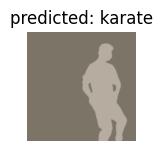

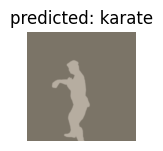

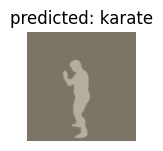

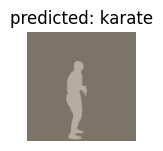

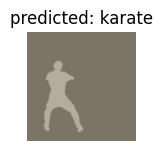

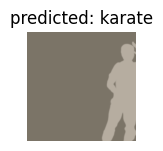

In [27]:
visualize_model(model_ft)

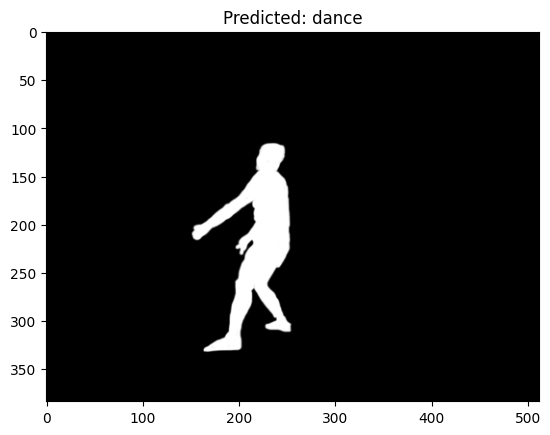

In [46]:
def visualize_model_simple_predict(model, img_path, transforms):
    # Set model to evaluation mode
    model.eval()

    # Load image
    img = Image.open(img_path)

    # If the image has an alpha channel, convert it to an RGB image
    if img.mode == 'RGBA':
        img = img.convert('RGB')

    # Apply transformations
    img_transformed = transforms(img)

    # Add an extra dimension at the beginning for the batch size
    img_transformed = img_transformed.unsqueeze(0)

    # Move image to the device that the model is on
    img_transformed = img_transformed.to(device)

    # Pass image through model
    with torch.no_grad():
        outputs = model(img_transformed)

    # Get predicted class
    _, preds = torch.max(outputs, 1)

    # Define class names
    class_names = ['dance', 'karate']  # replace with your actual class names

    # Display image and prediction
    plt.imshow(img)
    plt.title(f'Predicted: {class_names[preds[0]]}')
    plt.show()

# Usage:
visualize_model_simple_predict(model_ft, 'data/val/dance/Sports_Volleyball_C2_00990.png', data_transforms['train'])

## VISUALIZE TUNED MODEL'S PREDICTION 

In [85]:
# visualize_model(model_conv)

# plt.ioff()
# plt.show()

### TRAINING MODEL TO DETECT

## SLIDING WINDOW IMPLEMENTATION

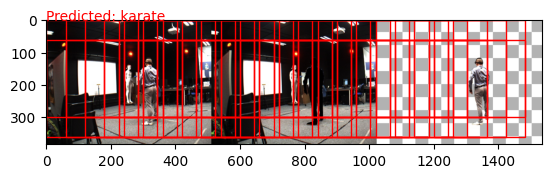

In [107]:
# import matplotlib.patches as patches

# def sliding_window_recognition(model, img_path, transforms, window_size=(224, 224), step_size=100):
#     # Set model to evaluation mode
#     model.eval()

#     # Load image
#     img = Image.open(img_path)

#     # If the image has an alpha channel, convert it to an RGB image
#     if img.mode == 'RGBA':
#         img = img.convert('RGB')

#     # Define class names
#     class_names = ['dance', 'karate']  # replace with your actual class names

#     # Create a matplotlib figure and axes
#     fig, ax = plt.subplots(1)

#     # Display the image
#     ax.imshow(img)

#     # Slide a window across the image
#     for y in range(0, img.height - window_size[1] + 1, step_size):
#         for x in range(0, img.width - window_size[0] + 1, step_size):
#             # Extract the window from the image
#             window = img.crop((x, y, x + window_size[0], y + window_size[1]))

#             # Apply transformations
#             window_transformed = transforms(window)

#             # Add an extra dimension at the beginning for the batch size
#             window_transformed = window_transformed.unsqueeze(0)

#             # Move window to the device that the model is on
#             window_transformed = window_transformed.to(device)

#             # Pass window through model
#             with torch.no_grad():
#                 outputs = model(window_transformed)

#             # Get predicted class
#             _, preds = torch.max(outputs, 1)

#             # Create a Rectangle patch
#             rect = patches.Rectangle((x, y), window_size[0], window_size[1], linewidth=1, edgecolor='r', facecolor='none')

#             # Add the patch to the Axes
#             ax.add_patch(rect)

#             # Annotate the prediction
#             plt.text(x, y, f'Predicted: {class_names[preds[0]]}', color='r')

#     # Show the figure
#     plt.show()

# # Usage:
# sliding_window_recognition(model_ft, 'data/val/dance/Sports_Volleyball_C2_00990.png', data_transforms['val'])


############################## WITH NMS
# from torchvision.ops import nms

# def sliding_window_recognition(model, img_path, transforms, window_size=(224, 270), step_size=100):
#     # Set model to evaluation mode
#     model.eval()

#     # Load image
#     img = Image.open(img_path)

#     # If the image has an alpha channel, convert it to an RGB image
#     if img.mode == 'RGBA':
#         img = img.convert('RGB')

#     # Define class names
#     class_names = ['dance', 'karate']  # replace with your actual class names

#     # Create a matplotlib figure and axes
#     fig, ax = plt.subplots(1)

#     # Display the image
#     ax.imshow(img)

#     # Initialize a list to store the bounding boxes and predictions
#     boxes_and_scores = []

#     # Slide a window across the image
#     for y in range(0, img.height - window_size[1] + 1, step_size):
#         for x in range(0, img.width - window_size[0] + 1, step_size):
#             # Extract the window from the image
#             window = img.crop((x, y, x + window_size[0], y + window_size[1]))

#             # Apply transformations
#             window_transformed = transforms(window)

#             # Add an extra dimension at the beginning for the batch size
#             window_transformed = window_transformed.unsqueeze(0)

#             # Move window to the device that the model is on
#             window_transformed = window_transformed.to(device)

#             # Pass window through model
#             with torch.no_grad():
#                 outputs = model(window_transformed)

#             # Get predicted class and confidence score
#             conf_scores, preds = torch.max(outputs, 1)

#             # Store the bounding box and prediction
#             boxes_and_scores.append(((x, y, x + window_size[0], y + window_size[1]), conf_scores.item(), preds.item()))

#     # Convert boxes and scores to PyTorch tensors
#     boxes = torch.tensor([box for box, _ in boxes_and_scores]).float()
#     scores = torch.tensor([score for _, score in boxes_and_scores]).float()

#     # Apply non-maximum suppression
#     keep = nms(boxes, scores, iou_threshold=0.5)

#     # Draw the bounding boxes
#     for i in keep:
#         (x, y, width, height), _ = boxes_and_scores[i]
#         # Create a Rectangle patch
#         rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')

#         # Add the patch to the Axes
#         ax.add_patch(rect)

#     # Get the most common prediction
#     # Get the most common prediction
#     preds = [pred for _, _, pred in boxes_and_scores]
#     most_common_pred = Counter(preds).most_common(1)[0][0]

#     # Annotate the prediction
#     plt.text(0, 0, f'Predicted: {class_names[most_common_pred]}', color='r')

#     # Show the figure
#     plt.show()

# # Usage:
# sliding_window_recognition(model_ft, 'test/Jazz_Jazz2_C2_00180.png', data_transforms['val'])



import matplotlib.patches as patches
from collections import Counter

def sliding_window_recognition(model, img_path, transforms, window_size=(224, 300), step_size=60):
    # Set model to evaluation mode
    model.eval()

    # Load image
    img = Image.open(img_path)

    # If the image has an alpha channel, convert it to an RGB image
    if img.mode == 'RGBA':
        img = img.convert('RGB')

    # Define class names
    class_names = ['dance', 'karate']  # replace with your actual class names

    # Create a matplotlib figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)

    # Initialize a list to store the bounding boxes and predictions
    boxes_and_preds = []

    # Slide a window across the image
    for y in range(0, img.height - window_size[1] + 1, step_size):
        for x in range(0, img.width - window_size[0] + 1, step_size):
            # Extract the window from the image
            window = img.crop((x, y, x + window_size[0], y + window_size[1]))

            # Apply transformations
            window_transformed = transforms(window)

            # Add an extra dimension at the beginning for the batch size
            window_transformed = window_transformed.unsqueeze(0)

            # Move window to the device that the model is on
            window_transformed = window_transformed.to(device)

            # Pass window through model
            with torch.no_grad():
                outputs = model(window_transformed)

            # Get predicted class
            _, preds = torch.max(outputs, 1)

            # Store the bounding box and prediction
            boxes_and_preds.append(((x, y, window_size[0], window_size[1]), preds[0]))

    # Draw the bounding boxes
    for (x, y, width, height), _ in boxes_and_preds:
        # Create a Rectangle patch
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    # Get the most common prediction
    preds = [pred for _, pred in boxes_and_preds]
    most_common_pred = Counter(preds).most_common(1)[0][0]

    # Annotate the prediction
    plt.text(0, 0, f'Predicted: {class_names[most_common_pred]}', color='r')

    # Show the figure
    plt.show()

# Usage:
sliding_window_recognition(model_ft, 'test/HipHop_HipHop5_C2_00135.jpg', data_transforms['val'])




## OBED

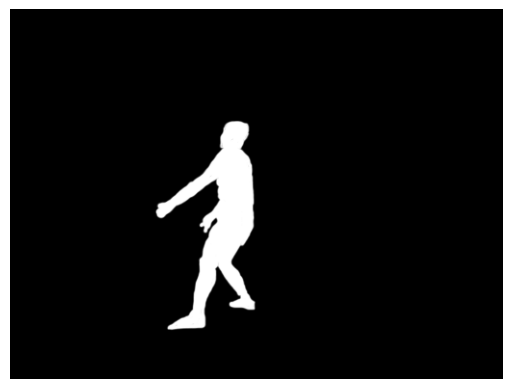

In [66]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


# Set the model to evaluation mode
model_ft.eval()
# Define the minimum size for the sliding window
min_window_size = (224, 224)
stride = 20
confidence_threshold = 0.9
nms_threshold = 0.1

transform = T.Compose([
    T.ToTensor()
])

input_image = Image.open('data/val/dance/Sports_Volleyball_C2_00990.png')
input_image1 = input_image.convert('RGB')
input_tensor = transform(input_image1)

image_width, image_height = input_image.size

# Apply the sliding window
predictions = []

for y in range(0, image_height - min_window_size[1], stride):
    for x in range(0, image_width - min_window_size[0], stride):
        # Determine the window size based on the detected object
        window_size = min_window_size
        
        # Extract the window from the image
        window = input_tensor[:, y:y+window_size[1], x:x+window_size[0]].unsqueeze(0)
        
        with torch.no_grad():
            output = model_ft(window)
            _, predicted_class = torch.max(output, 1)
            confidence = torch.softmax(output, dim=1)[0][predicted_class.item()].item()
        
        # Filter by confidence threshold
        if confidence > confidence_threshold:
            predictions.append((predicted_class.item(), confidence, (x, y, x+window_size[0], y+window_size[1])))

# Apply non-maximum suppression (NMS)
def nms(predictions, threshold):
    if not predictions:
        return []
    
    # Sort predictions by decreasing confidence
    predictions.sort(key=lambda x: x[1], reverse=True)
    picked_predictions = []

    while predictions:
        best_prediction = predictions.pop(0)
        picked_predictions.append(best_prediction)

        # Calculate intersection over union (IoU) with other predictions
        other_predictions = []
        for pred in predictions:
            box1 = best_prediction[2]
            box2 = pred[2]
            x1 = max(box1[0], box2[0])
            y1 = max(box1[1], box2[1])
            x2 = min(box1[2], box2[2])
            y2 = min(box1[3], box2[3])
            intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
            area1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
            area2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
            iou = intersection / float(area1 + area2 - intersection)
            if iou <= threshold:
                other_predictions.append(pred)
        
        predictions = other_predictions

    return picked_predictions

predictions_after_nms = nms(predictions, nms_threshold)

# Display the results after NMS
plt.imshow(input_image)
ax = plt.gca()

for pred_class, confidence, (x1, y1, x2, y2) in predictions_after_nms:
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='r', linewidth=1)
    ax.add_patch(rect)
    plt.text(x1, y1, f'Object ({confidence:.2f})', color='r', verticalalignment='top')

plt.axis('off')
plt.show()

## FINETUNING

In [28]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [30]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6657 Acc: 0.6331
val Loss: 0.6433 Acc: 0.6614

Epoch 1/4
----------
train Loss: 0.6328 Acc: 0.6770
val Loss: 0.7312 Acc: 0.5556

Epoch 2/4
----------
train Loss: 0.5842 Acc: 0.7049
val Loss: 0.8022 Acc: 0.6032

Epoch 3/4
----------
train Loss: 0.5325 Acc: 0.7198
val Loss: 0.6594 Acc: 0.6455

Epoch 4/4
----------
train Loss: 0.5882 Acc: 0.7129
val Loss: 1.3127 Acc: 0.4286

Training complete in 10m 7s
Best val Acc: 0.661376


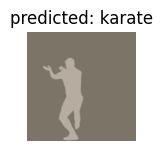

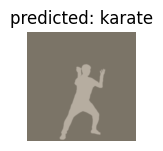

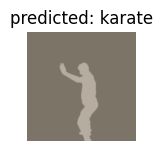

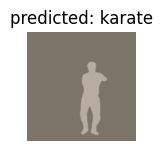

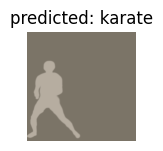

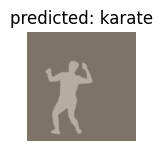

In [37]:
def visualize_model_predictions(model, img_path, data_transforms, device, class_names, imshow):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    
    # Convert the image to RGB if it's RGBA
    if img.mode == 'RGBA':
        img = img.convert('RGB')

    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

    model.train(mode=was_training)

In [38]:
visualize_model_predictions(
    model_conv,
    img_path='data/train/karate/Kata_F2_C0_00090.png'
)

plt.ioff()
plt.show()

TypeError: visualize_model_predictions() missing 4 required positional arguments: 'data_transforms', 'device', 'class_names', and 'imshow'